In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

In [2]:
TRANSFER = True

if TRANSFER:
    # Tranfer learning
    ijr = pd.read_csv("data/transfer/IJR.csv")
    iwm = pd.read_csv("data/transfer/IWM.csv")
    tlt = pd.read_csv("data/transfer/TLT.csv")

else:
    botz = pd.read_csv("data/BOTZ.csv")
    spy = pd.read_csv("data/SPY.csv")
    iwda = pd.read_csv("data/IWDA.AS.csv")
    dax = pd.read_csv("data/DAX.csv")
    eem = pd.read_csv("data/EEM.csv")
    ixic = pd.read_csv("data/IXIC.csv")
    icln = pd.read_csv("data/ICLN.csv")
    dia = pd.read_csv("data/DIA.csv")

In [3]:
# Function to calculate the RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()

    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

In [4]:
def prepare_financial_data(data):
    # Convert the 'Date' column in the DataFrame to Timestamp objects
    data['Date'] = pd.to_datetime(data['Date'])

    # Calculating 5 and 30-day SMA
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_30'] = data['Close'].rolling(window=30).mean()

    # Calculating 20-day SMA for Bollinger Bands
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    # Calculating the standard deviation
    data['STD_20'] = data['Close'].rolling(window=20).std()
    # Calculating Upper and Lower Bollinger Bands
    data['Upper_Band'] = data['SMA_20'] + (data['STD_20'] * 2)
    data['Lower_Band'] = data['SMA_20'] - (data['STD_20'] * 2)

    # Normalize volume bars to the range [0, 1] for better visual consistency
    data['normalized_volume'] = (data['Volume'] - data['Volume'].min()) / (data['Volume'].max() - data['Volume'].min())

    # Calculate daily returns for Volatility
    data['Daily_Return'] = data['Close'].pct_change()

    # Calculate rolling 30-day Volatility
    data['Volatility_30'] = data['Daily_Return'].rolling(window=30).std()

    # Calculate RSI
    data['RSI'] = calculate_rsi(data)

    return data

In [5]:
etfs = {}

if TRANSFER:
    ijr = prepare_financial_data(ijr)
    etfs["SmallCap"] = ijr
    iwm = prepare_financial_data(iwm)
    etfs["Russell2000"] = iwm
    tlt = prepare_financial_data(tlt)
    etfs["Treasury"] = tlt

else:
    spy = prepare_financial_data(spy)
    etfs["S&P500"] = spy
    botz = prepare_financial_data(botz)
    etfs["AI&Robotics"] = botz
    icln = prepare_financial_data(iwda)
    etfs["MSCIWorld"] = iwda
    dax = prepare_financial_data(dax)
    etfs["DAX"] = dax
    eem = prepare_financial_data(eem)
    etfs["EmergingMarkets"] = eem
    ixic = prepare_financial_data(ixic)
    etfs["NASDAQ"] = ixic
    dia = prepare_financial_data(dia)
    etfs["DowJones"] = dia
    icln = prepare_financial_data(icln)
    etfs["CleanEnergy"] = icln

In [6]:
def save_chart(fig, etf, start_date, timeframe, chart_type):
    # Specify the file path where you want to save the PNG image
    file_path = "images/" + chart_type + "/" + etf + "_" + str(start_date) + "_" + str(timeframe) + ".png"

    img = fig.to_image("png")

    # Save the PNG image to the specified file
    with open(file_path, "wb") as f:
        f.write(img)

    return file_path


In [7]:
def save_label(all_data, image_name, end_date, time_of_prediction):
    # Calculate the target date by adding the prediction offset to end_date
    target_date = pd.to_datetime(end_date) + pd.DateOffset(days=time_of_prediction)

    # Filter 'Close' values where 'Date' equals the target_date
    price_to_predict = all_data[all_data['Date'] == target_date]['Close']

    target_date = target_date + pd.DateOffset(days=1)

    # Loop until you find a non-empty price_to_predict or until target_date exceeds the maximum date
    while target_date <= all_data['Date'].max():
        price_to_predict = all_data[all_data['Date'] == target_date]['Close']
        
        if not price_to_predict.empty:
            break
        
        target_date = target_date + pd.DateOffset(days=1)

    # If target_date exceeds the maximum date, handle the situation (e.g., raise an exception)
    if target_date > all_data['Date'].max():
        raise ValueError("No data available for prediction within the specified timeframe")

    # Calculate if the price goes up (1) or down (0) after prediction_days
    end_date = pd.to_datetime(end_date)

    # Loop until you find a non-empty price_at_end or until target_date exceeds the maximum date
    while end_date <= all_data['Date'].max():
        price_at_end = all_data[all_data['Date'] == pd.to_datetime(end_date)]['Close']
        
        if not price_at_end.empty:
            break
        
        end_date = end_date + pd.DateOffset(days=1)

    # If target_date exceeds the maximum date, handle the situation (e.g., raise an exception)
    if end_date > all_data['Date'].max():
        raise ValueError("No data available for prediction within the specified timeframe")
    
    # Calculate the label
    label = 1 if price_at_end.iloc[0] < price_to_predict.iloc[0] else 0

    # Append the image name and label to the CSV file
    if TRANSFER:
        csv_file = 'transfer_labels.csv'    
    else:
        csv_file = 'labels.csv'
    data_to_append = pd.DataFrame({'Image': [image_name], 
                                   'TimePrediction': [time_of_prediction], 
                                    'LastPrice': [price_at_end.iloc[0]], 
                                   'FuturePrice': [price_to_predict.iloc[0]],
                                   'Label': [label]})
    if os.path.exists(csv_file):
        data_to_append.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        data_to_append.to_csv(csv_file, index=False)

In [8]:
def build_black_white_ohlc(etf, data, start_date, timeframe):
    # Filter the data for the specified date range
    data = data[(data['Date'] >= pd.to_datetime(start_date)) 
                & (data['Date'] <= pd.to_datetime(start_date) + pd.DateOffset(days=timeframe))]

    # Create figure with secondary y-axis for volume
    fig = go.Figure()

    # Add 30-day Moving Average
    fig.add_trace(go.Scatter(x=data['Date'], y=data['SMA_30'], mode='lines', name='30-day SMA', line=dict(color='white'), showlegend=False))

    # Normalize volume bars to the range [0, 1] for better visual consistency
    normalized_volume = (data['Volume'] - data['Volume'].min()) / (data['Volume'].max() - data['Volume'].min())
    # Add volume trace as bars
    fig.add_trace(go.Bar(x=data['Date'], y=normalized_volume, name='Volume', marker_color='white', yaxis='y2', showlegend=False))

    # Add traces for Candlestick
    fig.add_trace(go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'],
                                increasing_line_color='white', decreasing_line_color='white', name="Candlestick", showlegend=False))

   # Update layout to remove legends, axis descriptions, tickmarks, numbers, and dates
    fig.update_layout(
        showlegend=False,  # Remove the legend
        xaxis=dict(
            title="",  # Remove x-axis description
            tickvals=[],  # Remove x-axis tick values
            showticklabels=False  # Remove x-axis tick labels
        ),
        yaxis=dict(
            title="",  # Remove y-axis description
            tickvals=[],  # Remove y-axis tick values
            showticklabels=False  # Remove y-axis tick labels
        ),
        yaxis2=dict(
            range=[0, 4],  # Adjusted y-axis range for volume
            overlaying='y',
            title="",  # Remove y-axis2 description
            tickvals=[],  # Remove y-axis2 tick values
            showticklabels=False  # Remove y-axis2 tick labels
        ),
        xaxis_rangeslider_visible=False,  # Remove x-axis rangeslider
        paper_bgcolor='black',
        plot_bgcolor='black'
    )

    # Scale image based on timeframe
    if timeframe == 14:
        fig.update_layout(
            height=300,
            width=250
        )
    elif timeframe == 30:
        fig.update_layout(
            height=300,
            width=300
        )
    elif timeframe == 90:
        fig.update_layout(
            height=300,
            width=400
        )
    elif timeframe == 180:
        fig.update_layout(
            height=300,
            width=600
        )
    else:
        fig.update_layout(
            height=300,
            width=800
        )
    

    # Show the figure
    image_name = save_chart(fig, etf, start_date, timeframe, "OHLC")
    return image_name

In [9]:
def build_colored_ohlc(etf, data, start_date, timeframe):
    # Filter the data for the specified date range
    data = data[(data['Date'] >= pd.to_datetime(start_date)) 
                & (data['Date'] <= pd.to_datetime(start_date) + pd.DateOffset(days=timeframe))]

    # Create figure with secondary y-axis for volume
    fig = go.Figure()

    # Add volume trace as bars
    fig.add_trace(go.Bar(x=data['Date'], y=data['normalized_volume'], name='Volume', marker_color='white', yaxis='y2'))

    # Add traces for Bollinger Bands, SMA, and Candlestick
    fig.add_trace(go.Scatter(x=data['Date'], y=data['Upper_Band'], mode='lines', name='Upper Bollinger Band',
                            line=dict(width=1, color="blue")))
    fig.add_trace(go.Scatter(x=data['Date'], y=data['Lower_Band'], mode='lines', name='Lower Bollinger Band',
                            fill='tonexty', fillcolor='rgba(173,216,230, 0.2)', line=dict(width=1, color="blue")))
    fig.add_trace(go.Scatter(x=data['Date'], y=data['SMA_20'], mode='lines', name='20-day SMA', line=dict(width=1, color="white")))
    fig.add_trace(go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'],
                                name="Candlestick"))

    # Update layout to remove legends, axis descriptions, tickmarks, numbers, and dates
    fig.update_layout(
        showlegend=False,  # Remove the legend
        xaxis=dict(
            title="",  # Remove x-axis description
            tickvals=[],  # Remove x-axis tick values
            showticklabels=False  # Remove x-axis tick labels
        ),
        yaxis=dict(
            title="",  # Remove y-axis description
            tickvals=[],  # Remove y-axis tick values
            showticklabels=False  # Remove y-axis tick labels
        ),
        yaxis2=dict(
            range=[0, 4],  # Adjusted y-axis range for volume
            overlaying='y',
            title="",  # Remove y-axis2 description
            tickvals=[],  # Remove y-axis2 tick values
            showticklabels=False  # Remove y-axis2 tick labels
        ),
        xaxis_rangeslider_visible=False,  # Remove x-axis rangeslider
        paper_bgcolor='black',
        plot_bgcolor='black'
    )

    # Scale image based on timeframe
    if timeframe == 14:
        fig.update_layout(
            height=300,
            width=250
        )
    elif timeframe == 30:
        fig.update_layout(
            height=300,
            width=300
        )
    elif timeframe == 90:
        fig.update_layout(
            height=300,
            width=400
        )
    elif timeframe == 180:
        fig.update_layout(
            height=300,
            width=600
        )
    else:
        fig.update_layout(
            height=300,
            width=800
        )

    # Save image and label
    image_name = save_chart(fig, etf, start_date, timeframe, "ColoredOHLC")
    return image_name

In [34]:
def build_ma_vol_rsi(etf, data, start_date, timeframe):
    # Filter the data for the specified date range
    data = data[(data['Date'] >= pd.to_datetime(start_date)) 
                & (data['Date'] <= pd.to_datetime(start_date) + pd.DateOffset(days=timeframe))]

    # Create a subplot layout with two rows
    line_chart = go.Figure()

    # Create a subplot layout with two rows
    line_chart = make_subplots(rows=1, cols=1, shared_xaxes=True, 
                            specs=[[{"secondary_y": True}]])

    # Add closing prices and SMA_20 to the first row
    line_chart.add_trace(go.Scatter(x=data['Date'], y=data['Close'], mode='lines', name='Close Price', yaxis='y1', line=dict(color='white')))
    line_chart.add_trace(go.Scatter(x=data['Date'], y=data['SMA_20'], mode='lines', name='20-day SMA', line=dict(width=1, color='white', dash='dot')))

    # Add traces for Bollinger Bands, SMA, and Candlestick
    line_chart.add_trace(go.Scatter(x=data['Date'], y=data['Upper_Band'], mode='lines', name='Upper Bollinger Band',
                            line=dict(width=1, color="blue")))
    line_chart.add_trace(go.Scatter(x=data['Date'], y=data['Lower_Band'], mode='lines', name='Lower Bollinger Band',
                            fill='tonexty', fillcolor='rgba(173,216,230, 0.2)', line=dict(width=1, color="blue")))

    area_start = start_date
    # Find periods of overbought and oversold to add shapes
    for i in range(1, len(data['RSI'])):
        if data['RSI'].iloc[i - 1] <= 70 and data['RSI'].iloc[i] > 70:  # Entering overbought
            area_start = data['Date'].iloc[i]
        elif data['RSI'].iloc[i - 1] > 70 and data['RSI'].iloc[i] <= 70:  # Exiting overbought
            line_chart.add_shape(type='rect', x0=area_start, x1=data['Date'].iloc[i], 
                        y0=data['Close'].min()* 0.95, y1=data['Close'].max()* 1.05,
                        line=dict(width=0), fillcolor='red', opacity=0.2)

        if data['RSI'].iloc[i - 1] >= 30 and data['RSI'].iloc[i] < 30:  # Entering oversold
            area_start = data['Date'].iloc[i]
        elif data['RSI'].iloc[i - 1] < 30 and data['RSI'].iloc[i] >= 30:  # Exiting oversold
            line_chart.add_shape(type='rect', x0=area_start, x1=data['Date'].iloc[i], 
                        y0=data['Close'].min()* 0.95, y1=data['Close'].max()* 1.05,
                        line=dict(width=0), fillcolor='green', opacity=0.2)

    # Add Volatility to the second row (Secondary Y-Axis)
    line_chart.add_trace(go.Scatter(x=data['Date'], y=data['Volatility_30'] * 100, mode='lines', name='30-day Volatility (%)', yaxis='y2', line=dict(width=1,color='grey')))

    line_chart.update_layout(
        showlegend=False,
        xaxis=dict(showgrid=False, title="", tickvals=[], showticklabels=False),
        yaxis=dict(showgrid=False, tickvals=[], showticklabels=False, side="left", range=[data['Close'].min() * 0.95, data['Close'].max() * 1.05]),
        yaxis2=dict(showgrid=False, tickvals=[], showticklabels=False, side="right"),
        paper_bgcolor='black',
        plot_bgcolor='black'
        )

    # Scale image based on timeframe
    if timeframe == 14:
        line_chart.update_layout(
            height=300,
            width=250
        )
    elif timeframe == 30:
        line_chart.update_layout(
            height=300,
            width=300
        )
    elif timeframe == 90:
        line_chart.update_layout(
            height=300,
            width=400
        )
    elif timeframe == 180:
        line_chart.update_layout(
            height=300,
            width=600
        )
    else:
        line_chart.update_layout(
            height=300,
            width=800
        )
    print(start_date)
    # Save image and label
    image_name = save_chart(line_chart, etf, start_date, timeframe, "Line")
    return image_name

In [11]:
# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms

def connect_tops_and_bottoms(tops, bottoms, data):
    # Combine tops and bottoms and sort by index
    combined = sorted(tops + bottoms, key=lambda x: x[1])
    dates = [data.index[point[1]] for point in combined]
    prices = [point[2] for point in combined]

    return dates, prices

In [12]:
def identify_and_connect_doubles(tops_bottoms, time_frame, price_diff, df):
    double_patterns = []

    for i in range(len(tops_bottoms) - 1):
        for j in range(i + 1, len(tops_bottoms)):
            date_diff = df.index[tops_bottoms[j][1]] - df.index[tops_bottoms[i][1]]
            price_diff_pct = abs(tops_bottoms[j][2] - tops_bottoms[i][2]) / tops_bottoms[i][2] * 100

            # Check if the tops/bottoms are within the specified time frame and price difference
            if date_diff.days <= time_frame and price_diff_pct < price_diff:
                double_patterns.append((tops_bottoms[i], tops_bottoms[j]))

    return double_patterns


In [13]:
# Create two functions to calculate if a level is SUPPORT or a RESISTANCE level through fractal identification
def is_Suppport_Level(df, i):
    support = df['Low'][i] < df['Low'][i - 1] and df['Low'][i] < df['Low'][i + 1] and df['Low'][i + 1] < df['Low'][i + 2] and df['Low'][i - 1] < df['Low'][i - 2]
    return support

def is_Resistance_Level(df, i):
    resistance = df['High'][i] > df['High'][i - 1] and df['High'][i] > df['High'][i + 1] and df['High'][i + 1] > df['High'][i + 2] and df['High'][i - 1] > df['High'][i - 2]
    return resistance

# This function, given a price value, returns True or False depending on if it is too near to some previously discovered key level.
def distance_from_mean(level, levels, mean):
    return np.sum([abs(level - y) < mean for y in levels]) == 0

In [14]:
def add_breakout_line(fig, pattern, data, time_frame, top):
    # pattern[0] and pattern[1] are the two tops/bottoms, pattern[2] is the confirming point (trough/peak)

    if top==True:  # For double tops, use the lowest point between tops
        confirming_idx = min(range(pattern[0][1], pattern[1][1]), key=lambda x: data.iloc[x]['Close'])
    else:  # For double bottoms, use the highest point between bottoms
        confirming_idx = max(range(pattern[0][1], pattern[1][1]), key=lambda x: data.iloc[x]['Close'])

    breakout_level = data.iloc[confirming_idx]['Close']
    start_date = data.index[confirming_idx]  # Start from the second top/bottom
    end_date = start_date + pd.Timedelta(days=time_frame)

    fig.add_trace(go.Scatter(x=[start_date, end_date], y=[breakout_level, breakout_level], mode='lines', line=dict(color='white'), name='Breakout Line'))

In [15]:
def build_trading_viz(etf, data, start_date, timeframe): 
    # Filter the data for the specified date range
    data = data[(data['Date'] >= pd.to_datetime(start_date)) 
                & (data['Date'] <= pd.to_datetime(start_date) + pd.DateOffset(days=timeframe))]

    # Initialize Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Candlestick(x=data['Date'], open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'],
                                    name="Candlestick"))
                                    
    price_diff = 2  # percentage
    data['Date'] = data['Date'].astype('datetime64[s]')
    data = data.set_index('Date')

    if timeframe == 14:
        tops, bottoms = rw_extremes(data['Close'].to_numpy(), 1)
        time_frame = 7  # days
    elif timeframe == 30:
        tops, bottoms = rw_extremes(data['Close'].to_numpy(), 3)
        time_frame = 15  # days
    elif timeframe == 90:
        tops, bottoms = rw_extremes(data['Close'].to_numpy(), 5)
        time_frame = 30  # days
    else:
        tops, bottoms = rw_extremes(data['Close'].to_numpy(), 10)
        time_frame = 45  # days
    data['Close'].plot()
    idx = data.index

    # Identify double tops and bottoms
    double_tops = identify_and_connect_doubles(tops, time_frame, price_diff, data)
    double_bottoms = identify_and_connect_doubles(bottoms, time_frame, price_diff, data)

    # Creating a list and feeding it the identified support and resistance levels via the Support and Resistance functions
    first_levels = []
    first_level_types = []
    for i in range(2, data.shape[0] - 2):

        if is_Suppport_Level(data, i):
            first_levels.append((i, data['Low'][i].round(2)))
            first_level_types.append('Support')

        elif is_Resistance_Level(data, i):
            first_levels.append((i, data['High'][i].round(2)))
            first_level_types.append('Resistance')

    # Clean noise in data by discarding a level if it is near another
    # (i.e. if distance to the next level is less than the average candle size for any given day - this will give a rough estimate on volatility)
    mean = np.mean(data['High'] - data['Low'])
    
    # Optimizing the analysis by adjusting the data and eliminating the noise from volatility that is causing multiple levels to show/overlapp
    levels = []
    level_types = []
    for i in range(2, data.shape[0] - 2):

        if is_Suppport_Level(data, i):
            level = data['Low'][i].round(2)

            if distance_from_mean(level, levels, mean):
                levels.append((i, level))
                level_types.append('Support')

        elif is_Resistance_Level(data, i):
            level = data['High'][i].round(2)

            if distance_from_mean(level, levels, mean):
                levels.append((i, level))
                level_types.append('Resistance')

    # Plot ETF close prices
    #fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', line=dict(color='grey', width=1),  name='Close Price'))

    # Connect tops and bottoms
    connect_dates, connect_prices = connect_tops_and_bottoms(tops, bottoms, data)

    # Add the connecting line to the figure
    fig.add_trace(go.Scatter(x=connect_dates, y=connect_prices, mode='lines', line=dict(color='white', width=2), name='Trend Line'))

    # Plot individual tops as green markers
    for top in tops:
        fig.add_trace(go.Scatter(x=[data.index[top[1]]], y=[top[2]], mode='markers', marker=dict(color='green', size=3), name='Top'))

    # Plot individual bottoms as red markers
    for bottom in bottoms:
        fig.add_trace(go.Scatter(x=[data.index[bottom[1]]], y=[bottom[2]], mode='markers', marker=dict(color='red', size=3), name='Bottom'))

    # Plot connected double tops with green lines
    for dt in double_tops:
        dt_dates = [data.index[dt[0][1]], data.index[dt[1][1]]]
        dt_prices = [dt[0][2], dt[1][2]]
        fig.add_trace(go.Scatter(x=dt_dates, y=dt_prices, mode='lines+markers', marker=dict(color='green', size=5), line=dict(color='green'), name='Double Top'))

    # Plot connected double bottoms with red lines
    for db in double_bottoms:
        db_dates = [data.index[db[0][1]], data.index[db[1][1]]]
        db_prices = [db[0][2], db[1][2]]
        fig.add_trace(go.Scatter(x=db_dates, y=db_prices, mode='lines+markers', marker=dict(color='red', size=5), line=dict(color='red'), name='Double Bottom'))

    # Add breakout lines for double tops and bottoms
    for dt in double_tops:
        add_breakout_line(fig, dt, data, 90, True)

    for db in double_bottoms:
        add_breakout_line(fig, db, data, 90, False)

    # Loop through levels and plot
    for level, level_type in zip(levels, level_types):
        index, price_level = level
        color = 'violet' if level_type == 'Support' else 'blue'
        
        # Add a horizontal line for each level
        fig.add_trace(go.Scatter(x=[data.index[index], data.index[-1]], y=[price_level, price_level], mode='lines', line=dict(color=color, width=0.5), name=level_type))

    # Update layout
    fig.update_layout(
        xaxis=dict(
        showgrid=False,
        title="",
        tickvals=[], 
        showticklabels=False
        ),
        yaxis=dict(
        title='',
        showgrid=False,
        tickvals=[], 
        showticklabels=False),
        xaxis_rangeslider_visible=False,
        paper_bgcolor='black',  # Set the background color to black
        plot_bgcolor='black',  # Set the plot background color to black
        showlegend=False)
  
    # Scale image based on timeframe
    if timeframe == 14:
        fig.update_layout(
            height=300,
            width=250
        )
    elif timeframe == 30:
        fig.update_layout(
            height=300,
            width=300
        )
    elif timeframe == 90:
        fig.update_layout(
            height=300,
            width=400
        )
    elif timeframe == 180:
        fig.update_layout(
            height=300,
            width=600
        )
    else:
        fig.update_layout(
            height=300,
            width=800
        )

    # Save image and label
    image_name = save_chart(fig, etf, start_date, timeframe, "AlgoTrading")
    return image_name

In [36]:
START = "2019-02-01"
END = "2023-12-01"
TIMEFRAMES = [14, 30, 90, 180, 365]
PREDICTIONS = [5, 30, 90]
STEPS = 60

In [37]:
# Iterate ETFs
for key in etfs:
    print(key)
    # Iterate timeframes
    for tf in TIMEFRAMES:
        start_date = pd.to_datetime(START)

        # Create images multiple times
        # While timeframe is possible to chart
        while start_date + pd.DateOffset(days=tf) < pd.to_datetime(END):
            # Create chart image
            image_name = build_black_white_ohlc(key, etfs[key], start_date, tf)
            
            # Set end date of chart
            end_date = start_date + pd.DateOffset(days=tf)

            # Iterate prediction timeframe
            for prediction in PREDICTIONS:

                # Only predict if prediction timesframe is smaller than chart timeframe
                if prediction <= tf:
                    # Save label in csv file
                    save_label(etfs[key], image_name, start_date, prediction)
            
            start_date = start_date + pd.DateOffset(days=STEPS)

SmallCap
Russell2000
Treasury


In [38]:
# Iterate ETFs
for key in etfs:
    print(key)
    # Iterate timeframes
    for tf in TIMEFRAMES:
        start_date = pd.to_datetime(START)

        # Create images multiple times
        # While timeframe is possible to chart
        while start_date + pd.DateOffset(days=tf) <= pd.to_datetime(END):
            # Create chart image
            image_name = build_colored_ohlc(key, etfs[key], start_date, tf)
            
            # Set end date of chart
            end_date = start_date + pd.DateOffset(days=tf)

            # Iterate prediction timeframe
            for prediction in PREDICTIONS:

                # Only predict if prediction timesframe is smaller than chart timeframe
                if prediction <= tf:
                    # Save label in csv file
                    save_label(etfs[key], image_name, start_date, prediction)
            
            # Set start_date
            start_date = start_date + pd.DateOffset(days=STEPS)

SmallCap
Russell2000
Treasury


In [39]:
# Iterate ETFs
for key in etfs:
    print(key)
    # Iterate timeframes
    for tf in TIMEFRAMES:
        start_date = pd.to_datetime(START)

        # Create images multiple times
        # While timeframe is possible to chart
        while start_date + pd.DateOffset(days=tf) < pd.to_datetime(END):
            # Create chart image
            image_name = build_ma_vol_rsi(key, etfs[key], start_date, tf)
            
            # Set end date of chart
            end_date = start_date + pd.DateOffset(days=tf)

            # Iterate prediction timeframe
            for prediction in PREDICTIONS:

                # Only predict if prediction timesframe is smaller than chart timeframe
                if prediction <= tf:
                    # Save label in csv file
                    save_label(etfs[key], image_name, start_date, prediction)
            
            # Set start_date
            start_date = start_date + pd.DateOffset(days=STEPS)

SmallCap
2019-02-01 00:00:00
2019-04-02 00:00:00
2019-06-01 00:00:00
2019-07-31 00:00:00
2019-09-29 00:00:00
2019-11-28 00:00:00
2020-01-27 00:00:00
2020-03-27 00:00:00
2020-05-26 00:00:00
2020-07-25 00:00:00
2020-09-23 00:00:00
2020-11-22 00:00:00
2021-01-21 00:00:00
2021-03-22 00:00:00
2021-05-21 00:00:00
2021-07-20 00:00:00
2021-09-18 00:00:00
2021-11-17 00:00:00
2022-01-16 00:00:00
2022-03-17 00:00:00
2022-05-16 00:00:00
2022-07-15 00:00:00
2022-09-13 00:00:00
2022-11-12 00:00:00
2023-01-11 00:00:00
2023-03-12 00:00:00
2023-05-11 00:00:00
2023-07-10 00:00:00
2023-09-08 00:00:00
2023-11-07 00:00:00
2019-02-01 00:00:00
2019-04-02 00:00:00
2019-06-01 00:00:00
2019-07-31 00:00:00
2019-09-29 00:00:00
2019-11-28 00:00:00
2020-01-27 00:00:00
2020-03-27 00:00:00
2020-05-26 00:00:00
2020-07-25 00:00:00
2020-09-23 00:00:00
2020-11-22 00:00:00
2021-01-21 00:00:00
2021-03-22 00:00:00
2021-05-21 00:00:00
2021-07-20 00:00:00
2021-09-18 00:00:00
2021-11-17 00:00:00
2022-01-16 00:00:00
2022-03-17 

SmallCap


/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Russell2000


/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Treasury


/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_3058/2394514653.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

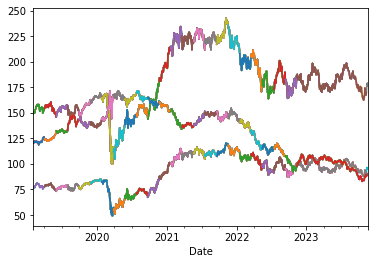

In [40]:
# Iterate ETFs
for key in etfs:
    print(key)
    # Iterate timeframes
    for tf in TIMEFRAMES:
        start_date = pd.to_datetime(START)

        # Create images multiple times
        # While timeframe is possible to chart
        while start_date + pd.DateOffset(days=tf) < pd.to_datetime(END):
            # Create chart image
            image_name = build_trading_viz(key, etfs[key], start_date, tf)
            
            # Set end date of chart
            end_date = start_date + pd.DateOffset(days=tf)

            # Iterate prediction timeframe
            for prediction in PREDICTIONS:

                # Only predict if prediction timesframe is smaller than chart timeframe
                if prediction <= tf:
                    # Save label in csv file
                    save_label(etfs[key], image_name, start_date, prediction)
            
            # Set start_date
            start_date = start_date + pd.DateOffset(days=STEPS)